In [1]:
%run ../../../shared_setup.ipynb

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [2]:
truth_dir = '/data/plasmodium/pfalciparum/pf-crosses/data/evaluation/truth'

In [3]:
gatk_callset_fn_template = '/data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/{cross}.gatk.final.npz'

In [4]:
def trim_alleles(a, b):

    # SNPs or already trimmed
    if len(a) == 1 or len(b) == 1:
        return a, b
    
    # sort by length, shortest first
    reverse = False
    if len(a) > len(b):
        a, b = b, a
        reverse = True
    
    # pick off reference base
    ref_base = a[0]
    assert a[0] == b[0], (a, b)
    
    # pick off suffix
    a_suffix = a[1:]
    b_suffix = b[1:]
    
    # trim
    if b_suffix.endswith(a_suffix):
        a = ref_base
        b = ref_base + b_suffix[:-1*len(a_suffix)]
        
    if reverse:
        return b, a
    else:
        return a, b 

In [5]:
def tabulate_variants_gatk(cross, parent):

    callset_gatk = np.load(gatk_callset_fn_template.format(cross=cross))
    variants = callset_gatk['variants']

    # select variants
    filter_condition = numexpr.evaluate('~FILTER_CNV & '
                                        '~FILTER_DUP_SITE & '
                                        '~FILTER_LOW_CONFIDENCE & '
                                        '~FILTER_LOW_CONFIDENCE_PARENT & '
                                        '~FILTER_MISSING_PARENT & '
                                        '~FILTER_NON_CORE & '
                                        '~FILTER_NON_MENDELIAN',
                                        local_dict=variants)
    log(callset_gatk['calldata'].dtype.names[parent])
    c2d = vcfnp.view2d(callset_gatk['calldata'])
    genotype = c2d['genotype']
    genotype_parent = genotype[:, parent]
    genotype_condition = genotype_parent > 0
    condition = filter_condition & genotype_condition
    log('n_variants', nnz(condition))

    # apply selection
    variants = np.compress(condition, variants)
    genotype_parent = np.compress(condition, genotype_parent)
    
    # construct table
    tbl = (etl
        .fromarray(variants)
        .addcolumn('genotype', genotype_parent)
        .cut('CHROM', 'POS', 'REF', 'ALT', 'genotype')
        .convert('ALT', lambda v, row: v[row.genotype-1], pass_row=True)
        .cutout('genotype')
        .convert(['CHROM', 'REF', 'ALT'], lambda v: str(v, 'ascii')) 
        .addfield('svlen', lambda row: len(row.ALT) - len(row.REF))
        .addfield('trim', lambda row: trim_alleles(row.REF, row.ALT))
        .unpack('trim', ['REF_trim', 'ALT_trim'])
        .addfield('svlen_trim', lambda row: len(row.ALT_trim) - len(row.REF_trim))
        .cutout('REF', 'ALT', 'svlen')
        .rename({'REF_trim': 'REF', 'ALT_trim': 'ALT', 'svlen_trim': 'svlen'})
        .addfield('svtype', lambda row: 'SNP' if row.svlen == 0 else 'INS' if row.svlen > 0 else 'DEL')
    )
    
    return tbl


In [6]:
def tabulate_variants_truth(alignment_method, calling_method, assembly):
    truth_vcf_fn = os.path.join(truth_dir, alignment_method, 'calling', calling_method, assembly + '.leftaligned.vcf.gz')

    # extract variants
    truth_variants = vcfnp.variants(truth_vcf_fn, 
                                    fields=['CHROM', 'POS', 'REF', 'ALT'],
                                    dtypes={'REF': 'S500', 'ALT': 'S500'},
                                    arities={'ALT': 4},
                                    cache=False)
    
    # extract genotype
    truth_genotype = vcfnp.calldata_2d(truth_vcf_fn, 
                                       fields=['genotype'], 
                                       ploidy=1,
                                       cache=False)['genotype'][:, 0]
    
    # tabulate
    tbl = (etl
        .fromarray(truth_variants)
        .addcolumn('genotype', truth_genotype)
        .convert('ALT', lambda v, row: v[row.genotype-1], pass_row=True)
        .cutout('genotype')
        .convert(['CHROM', 'REF', 'ALT'], lambda v: str(v, 'ascii')) 
        .addfield('svlen', lambda row: len(row.ALT) - len(row.REF))
        .addfield('trim', lambda row: trim_alleles(row.REF, row.ALT))
        .unpack('trim', ['REF_trim', 'ALT_trim'])
        .addfield('svlen_trim', lambda row: len(row.ALT_trim) - len(row.REF_trim))
        .cutout('REF', 'ALT', 'svlen')
        .rename({'REF_trim': 'REF', 'ALT_trim': 'ALT', 'svlen_trim': 'svlen'})
        .intervalleftjoin(tbl_regions_1b, lkey='CHROM', rkey='region_chrom',
                          lstart='POS', lstop='POS', rstart='region_start', rstop='region_stop',
                          include_stop=True)
        .eq('region_type', 'Core')
        .cutout('region_chrom', 'region_start', 'region_stop', 'region_type', 'region_size')
        .addfield('svtype', lambda row: 'SNP' if row.svlen == 0 else 'INS' if row.svlen > 0 else 'DEL')
    )

    return tbl

In [7]:
def load_coverage(alignment_method, assembly, rebuild=False):
    bam_fn = os.path.join(truth_dir, alignment_method, 'alignment', assembly + '.bam')
    cov_fn = bam_fn + '.coverage.npy'
    if not os.path.exists(cov_fn) or rebuild:
        cov = pysamstats.load_coverage(bam_fn, 
                                       pad=True, 
                                       fields=['chrom', 'pos', 'reads_all'],
                                       one_based=True)
        np.save(cov_fn, cov)
    else:
        cov = np.load(cov_fn).view(np.recarray)
    return cov

In [66]:
def join_truth(tbl_discovery, alignment_method, calling_method, assembly, key=('CHROM', 'POS')):
    
    # tabulate truth variants
    tbl_truth = tabulate_variants_truth(alignment_method, calling_method, assembly)
    
    # load coverage from truth assembly
    cov = load_coverage(alignment_method, assembly)
    cov_idx = allel.model.SortedMultiIndex(cov['chrom'], cov['pos'], copy=False)
#     tbl_cov = etl.fromarray(cov).convert('chrom', lambda v: str(v, 'ascii')).rename({'chrom': 'CHROM', 'pos': 'POS'})
    
    # tabulate
    tbl = (
        tbl_discovery
        .outerjoin(tbl_truth, key=key, rprefix='truth_')
        .addfield('truth_coverage', lambda row: cov.reads_all[cov_idx.locate_key(row.CHROM.encode('ascii'), row.POS)])
        .eq('truth_coverage', 1)
        # use a field we won't join with
        .addfield('status', lambda row: 'FP' if row.truth_svlen is None else 'FN' if row.svlen is None else 'TP')
        .intervaljoinvalues(tbl_exons, value='feature_id', lkey='CHROM', lstart='POS', lstop='POS', 
                            rkey='feature_chrom', rstart='feature_start', rstop='feature_stop', include_stop=True)
        .rename('feature_id', 'is_coding')
        .convert('is_coding', lambda v: len(v) > 0)
    )
    
    return tbl

In [76]:
def analyse_confusion(tbl_discovery, alignment_method, calling_method, assembly, join_key=('CHROM', 'POS')):
    
    # join with truth
    tbl_joined = join_truth(tbl_discovery, alignment_method, calling_method, assembly, key=join_key)
    df = tbl_joined.cut('svtype', 'truth_svtype', 'status', 'is_coding').todataframe()
    status = df.status
    is_coding = df.is_coding
    is_snp = (df.svtype == 'SNP')
    is_indel = (df.svtype == 'INS') | (df.svtype == 'DEL')
    is_truth_snp = (df.truth_svtype == 'SNP')
    is_truth_indel = (df.truth_svtype == 'INS') | (df.truth_svtype == 'DEL')
    
    fig = plt.figure(figsize=(8, 6))
    
    # coding SNP analyse confusion
    fp = nnz(is_coding & is_snp & (status == 'FP'))
    fn = nnz(is_coding & is_truth_snp & (status == 'FN'))
    tp = nnz(is_coding & is_snp & (status == 'TP'))
    print('coding SNP', 'TP', tp, 'FP', fp, 'FN', fn)
    print('coding SNP', 'FDR', fp / (fp + tp))
    print('coding SNP', 'sensitivity', tp / (fn + tp))
    from matplotlib_venn import venn2
    ax = fig.add_subplot(2, 2, 1)
    v = venn2(subsets=[fp, fn, tp], set_labels=['discovery', 'truth'], ax=ax)
    v.get_patch_by_id('10').set_color('#ff4444')
    v.get_patch_by_id('01').set_color('#4444ff')
    plt.gca().set_title('coding SNP')
    
    # non-coding SNP analyse confusion
    fp = nnz(~is_coding & is_snp & (status == 'FP'))
    fn = nnz(~is_coding & is_truth_snp & (status == 'FN'))
    tp = nnz(~is_coding & is_snp & (status == 'TP'))
    print('non-coding SNP', 'TP', tp, 'FP', fp, 'FN', fn)
    print('non-coding SNP', 'FDR', fp / (fp + tp))
    print('non-coding SNP', 'sensitivity', tp / (fn + tp))
    from matplotlib_venn import venn2
    ax = fig.add_subplot(2, 2, 2)
    v = venn2(subsets=[fp, fn, tp], set_labels=['discovery', 'truth'], ax=ax)
    v.get_patch_by_id('10').set_color('#ff4444')
    v.get_patch_by_id('01').set_color('#4444ff')
    plt.gca().set_title('non-coding SNP')
    
    # coding INDEL analyse confusion
    fp = nnz(is_coding & is_indel & (status == 'FP'))
    fn = nnz(is_coding & is_truth_indel & (status == 'FN'))
    tp = nnz(is_coding & is_indel & (status == 'TP'))
    print('coding INDEL', 'TP', tp, 'FP', fp, 'FN', fn)
    print('coding INDEL', 'FDR', fp / (fp + tp))
    print('coding INDEL', 'sensitivity', tp / (fn + tp))
    from matplotlib_venn import venn2
    ax = fig.add_subplot(2, 2, 3)
    v = venn2(subsets=[fp, fn, tp], set_labels=['discovery', 'truth'], ax=ax)
    v.get_patch_by_id('10').set_color('#ff4444')
    v.get_patch_by_id('01').set_color('#4444ff')
    plt.gca().set_title('coding INDEL')
    
    # non-coding INDEL analyse confusion
    fp = nnz(~is_coding & is_indel & (status == 'FP'))
    fn = nnz(~is_coding & is_truth_indel & (status == 'FN'))
    tp = nnz(~is_coding & is_indel & (status == 'TP'))
    print('non-coding INDEL', 'TP', tp, 'FP', fp, 'FN', fn)
    print('non-coding INDEL', 'FDR', fp / (fp + tp))
    print('non-coding INDEL', 'sensitivity', tp / (fn + tp))
    from matplotlib_venn import venn2
    ax = fig.add_subplot(2, 2, 4)
    v = venn2(subsets=[fp, fn, tp], set_labels=['discovery', 'truth'], ax=ax)
    v.get_patch_by_id('10').set_color('#ff4444')
    v.get_patch_by_id('01').set_color('#4444ff')
    plt.gca().set_title('non-coding INDEL')
    
    return tbl_joined

In [77]:
def confusion_tr_style(row):
    style = 'background-color: %s' % ('#4f4' if row.status == 'TP' 
                                      else '#f44' if row.status == 'FP'
                                      else '#44f' if row.status == 'FN'
                                      else 'white')
    return style

## 3D7 GATK versus Garimella

In [78]:
tbl_variants_gatk_3d7 = tabulate_variants_gatk('3d7_hb3', 0)
tbl_variants_gatk_3d7

2015-04-14 08:22:55.882245 :: 3D7/PG0051-C/ERR019061
2015-04-14 08:22:56.359055 :: n_variants 109


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype
Pf3D7_01_v3,108579,A,ATATT,4,INS
Pf3D7_01_v3,190317,CATAATA,C,-6,DEL
Pf3D7_01_v3,237483,AATAT,A,-4,DEL
Pf3D7_01_v3,273111,T,TTATA,4,INS
Pf3D7_01_v3,286838,AATATATATATAT,A,-12,DEL


[vcfnp] 2015-04-14 08:22:56.398867 :: caching is disabled
[vcfnp] 2015-04-14 08:22:56.399320 :: building array
[vcfnp] 2015-04-14 08:22:56.428384 :: caching is disabled
[vcfnp] 2015-04-14 08:22:56.428739 :: building array


coding SNP TP 0 FP 3 FN 34
coding SNP FDR 1.0
coding SNP sensitivity 0.0
non-coding SNP TP 1 FP 0 FN 213
non-coding SNP FDR 0.0
non-coding SNP sensitivity 0.004672897196261682
coding INDEL TP 7 FP 2 FN 6
coding INDEL FDR 0.2222222222222222
coding INDEL sensitivity 0.5384615384615384
non-coding INDEL TP 27 FP 16 FN 48
non-coding INDEL FDR 0.37209302325581395
non-coding INDEL sensitivity 0.36


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_REF,7|truth_ALT,8|truth_svlen,9|truth_svtype,10|truth_coverage,11|status,12|is_coding
Pf3D7_01_v3,102198,None,None,None,None,G,A,0,SNP,1,FN,True
Pf3D7_01_v3,190317,CATAATA,C,-6,DEL,CATAATA,C,-6,DEL,1,TP,True
Pf3D7_01_v3,202364,None,None,None,None,G,A,0,SNP,1,FN,False
Pf3D7_01_v3,219230,None,None,None,None,C,A,0,SNP,1,FN,False
Pf3D7_01_v3,237483,AATAT,A,-4,DEL,None,None,None,None,1,FP,False
Pf3D7_01_v3,273111,T,TTATA,4,INS,T,TTATATATATATATATATATATA,22,INS,1,TP,False
Pf3D7_01_v3,286630,None,None,None,None,C,T,0,SNP,1,FN,False
Pf3D7_01_v3,286838,AATATATATATAT,A,-12,DEL,AATATATATATAT,A,-12,DEL,1,TP,False
Pf3D7_01_v3,287205,None,None,None,None,T,TTATATA,6,INS,1,FN,False
Pf3D7_01_v3,288303,AATATATATATAT,A,-12,DEL,AATATATATATAT,A,-12,DEL,1,TP,False


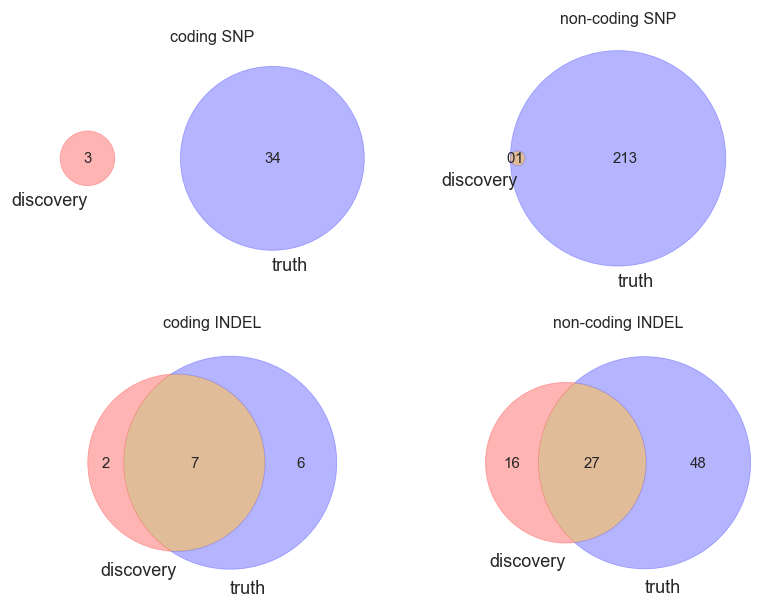

In [79]:
tbl_variants_gatk_3d7_truth_site = analyse_confusion(tbl_variants_gatk_3d7, 
                                                     alignment_method='bwamem_intractg', 
                                                     calling_method='bcftools_consensus', 
                                                     assembly='garimella_3d7_ERR019061_contigs',
                                                     join_key=('CHROM', 'POS'))

tbl_variants_gatk_3d7_truth_site.display(20, tr_style=confusion_tr_style)

In [75]:
# tbl_variants_gatk_3d7_truth_variant = analyse_confusion(tbl_variants_gatk_3d7, 
#                                                         alignment_method='bwamem_intractg', 
#                                                         calling_method='bcftools_consensus', 
#                                                         assembly='garimella_3d7_ERR019061_contigs',
#                                                         join_key=('CHROM', 'POS', 'svtype'))

# tbl_variants_gatk_3d7_truth_variant.display(20, tr_style=confusion_tr_style)

[vcfnp] 2015-04-14 08:23:43.229746 :: caching is disabled
[vcfnp] 2015-04-14 08:23:43.230125 :: building array
[vcfnp] 2015-04-14 08:23:43.256909 :: caching is disabled
[vcfnp] 2015-04-14 08:23:43.257446 :: building array


coding SNP TP 0 FP 3 FN 34
coding SNP FDR 1.0
coding SNP sensitivity 0.0
non-coding SNP TP 1 FP 0 FN 213
non-coding SNP FDR 0.0
non-coding SNP sensitivity 0.004672897196261682
coding INDEL TP 7 FP 2 FN 6
coding INDEL FDR 0.2222222222222222
coding INDEL sensitivity 0.5384615384615384
non-coding INDEL TP 24 FP 19 FN 51
non-coding INDEL FDR 0.4418604651162791
non-coding INDEL sensitivity 0.32


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|is_coding
Pf3D7_01_v3,102198,G,A,None,None,0,SNP,1,FN,True
Pf3D7_01_v3,190317,CATAATA,C,-6,DEL,-6,DEL,1,TP,True
Pf3D7_01_v3,202364,G,A,None,None,0,SNP,1,FN,False
Pf3D7_01_v3,219230,C,A,None,None,0,SNP,1,FN,False
Pf3D7_01_v3,237483,AATAT,A,-4,DEL,None,None,1,FP,False
Pf3D7_01_v3,273111,T,TTATA,4,INS,None,None,1,FP,False
Pf3D7_01_v3,273111,T,TTATATATATATATATATATATA,None,None,22,INS,1,FN,False
Pf3D7_01_v3,286630,C,T,None,None,0,SNP,1,FN,False
Pf3D7_01_v3,286838,AATATATATATAT,A,-12,DEL,-12,DEL,1,TP,False
Pf3D7_01_v3,287205,T,TTATATA,None,None,6,INS,1,FN,False


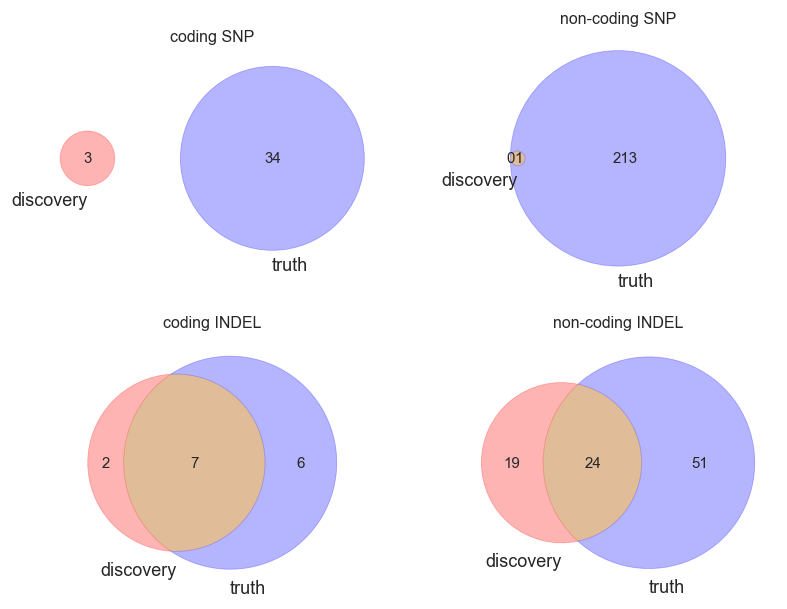

In [80]:
tbl_variants_gatk_3d7_truth_allele = analyse_confusion(tbl_variants_gatk_3d7, 
                                                       alignment_method='bwamem_intractg', 
                                                       calling_method='bcftools_consensus', 
                                                       assembly='garimella_3d7_ERR019061_contigs',
                                                       join_key=('CHROM', 'POS', 'REF', 'ALT'))

tbl_variants_gatk_3d7_truth_allele.display(20, tr_style=confusion_tr_style)

## HB3(1) GATK versus Garimella

In [81]:
tbl_variants_gatk_hb3_1 = tabulate_variants_gatk('3d7_hb3', 1)
tbl_variants_gatk_hb3_1

2015-04-14 08:24:37.542974 :: HB3/PG0052-C/ERR019054
2015-04-14 08:24:38.006922 :: n_variants 36635


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype
Pf3D7_01_v3,93901,AATATATATAT,A,-10,DEL
Pf3D7_01_v3,94590,T,TATAC,4,INS
Pf3D7_01_v3,94993,CATATAT,C,-6,DEL
Pf3D7_01_v3,95518,G,T,0,SNP
Pf3D7_01_v3,95621,T,A,0,SNP


[vcfnp] 2015-04-14 08:24:41.520911 :: caching is disabled
[vcfnp] 2015-04-14 08:24:41.521305 :: building array
[vcfnp] 2015-04-14 08:24:41.929368 :: caching is disabled
[vcfnp] 2015-04-14 08:24:41.929739 :: building array


coding SNP TP 6422 FP 418 FN 1856
coding SNP FDR 0.06111111111111111
coding SNP sensitivity 0.7757912539260691
non-coding SNP TP 3526 FP 113 FN 2669
non-coding SNP FDR 0.031052486946963453
non-coding SNP sensitivity 0.5691686844229217
coding INDEL TP 2411 FP 457 FN 807
coding INDEL FDR 0.1593444909344491
coding INDEL sensitivity 0.7492231199502797
non-coding INDEL TP 10180 FP 4480 FN 1723
non-coding INDEL FDR 0.30559345156889495
non-coding INDEL sensitivity 0.855246576493321


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_REF,7|truth_ALT,8|truth_svlen,9|truth_svtype,10|truth_coverage,11|status,12|is_coding
Pf3D7_01_v3,94590,T,TATAC,4,INS,T,TATAC,4,INS,1,TP,False
Pf3D7_01_v3,94993,CATATAT,C,-6,DEL,CATATAT,C,-6,DEL,1,TP,False
Pf3D7_01_v3,95518,G,T,0,SNP,G,T,0,SNP,1,TP,False
Pf3D7_01_v3,95621,T,A,0,SNP,T,A,0,SNP,1,TP,False
Pf3D7_01_v3,95632,G,A,0,SNP,G,A,0,SNP,1,TP,False
Pf3D7_01_v3,95641,G,A,0,SNP,G,A,0,SNP,1,TP,False
Pf3D7_01_v3,95680,A,G,0,SNP,A,G,0,SNP,1,TP,False
Pf3D7_01_v3,95685,G,T,0,SNP,G,T,0,SNP,1,TP,False
Pf3D7_01_v3,95686,A,C,0,SNP,A,C,0,SNP,1,TP,False
Pf3D7_01_v3,95710,G,C,0,SNP,G,C,0,SNP,1,TP,False


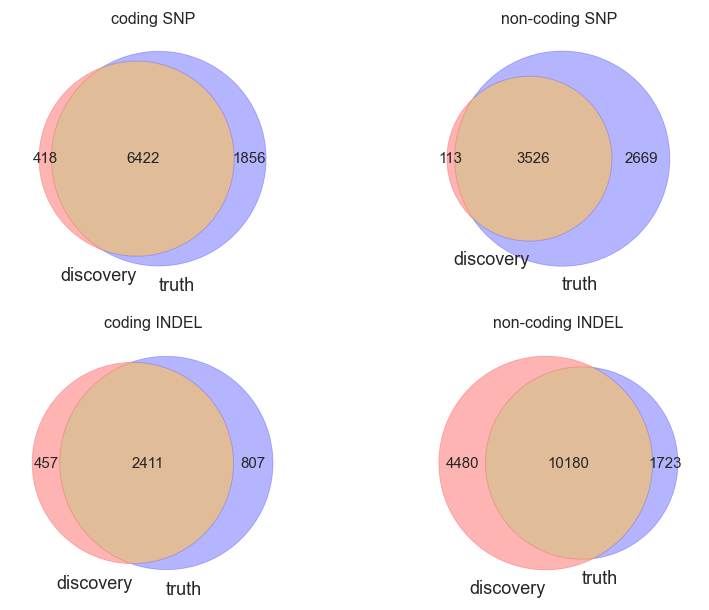

In [82]:
tbl_variants_gatk_hb3_1_truth_site = analyse_confusion(tbl_variants_gatk_hb3_1, 
                                                       alignment_method='bwamem_intractg', 
                                                       calling_method='bcftools_consensus', 
                                                       assembly='garimella_hb3_ERR019054_contigs',
                                                       join_key=('CHROM', 'POS'))

tbl_variants_gatk_hb3_1_truth_site.display(20, tr_style=confusion_tr_style)

In [ ]:
# tbl_variants_gatk_hb3_1_truth_variant = analyse_confusion(tbl_variants_gatk_hb3_1, 
#                                                        alignment_method='bwamem_intractg', 
#                                                        calling_method='bcftools_consensus', 
#                                                        assembly='garimella_hb3_ERR019054_contigs',
#                                                        join_key=('CHROM', 'POS', 'svtype'))

# tbl_variants_gatk_hb3_1_truth_variant.display(20, tr_style=confusion_tr_style)

In [ ]:
tbl_variants_gatk_hb3_1_truth_allele = analyse_confusion(tbl_variants_gatk_hb3_1, 
                                                       alignment_method='bwamem_intractg', 
                                                       calling_method='bcftools_consensus', 
                                                       assembly='garimella_hb3_ERR019054_contigs',
                                                       join_key=('CHROM', 'POS', 'REF', 'ALT'))

tbl_variants_gatk_hb3_1_truth_allele.display(20, tr_style=confusion_tr_style)

[vcfnp] 2015-04-14 08:35:00.855877 :: caching is disabled
[vcfnp] 2015-04-14 08:35:00.856231 :: building array
[vcfnp] 2015-04-14 08:35:01.280210 :: caching is disabled
[vcfnp] 2015-04-14 08:35:01.280570 :: building array


## Sandbox

In [80]:
cov = load_coverage('bwamem_intractg', 'garimella_3d7_ERR019061_contigs')

In [81]:
cov.size

23292622

In [82]:
cov.nbytes

465852440

In [83]:
cov.dtype

dtype([('chrom', 'S12'), ('pos', '<i4'), ('reads_all', '<i4')])

In [84]:
cov.pos

array([      1,       2,       3, ..., 3291934, 3291935, 3291936], dtype=int32)